# TFT(전략적 팀 전투) 랭크 게임 분석

In [104]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import json
import re 
import time
from pandas.io.json import json_normalize
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

## 1. Data Cleansing 

In [105]:
chall_game=pd.read_csv('TFT_Challenger_MatchData.csv')
gr_game=pd.read_csv('TFT_GrandMaster_MatchData.csv')
master_game=pd.read_csv('TFT_Master_MatchData.csv')
champ=pd.read_csv('TFT_Champion_CurrentVersion.csv')

#### 데이터 설명
- chall_game : 챌린저티어 게임
- gr_game : 그랜드마스터 티어 게임
- master_game : 마스터티어 게임
- champ : 챔피언 데이터

#### 칼럼 설명 
- 티어 구분 : 
    - 챌린저 : 1위~200위
    - 그랜드마스터 : 201위~500위
    - 마스터 : 501위~
- 티어 데이터
    - gameId : 유저 아이디
    - gameDuration : 총 게임 시간
    - level : 플레이어 레벨
    - lastRound : 현재 참가자의 마지막 라운드(사망 전 라운드)
    - Ranked : 게임 내 참가자 순위(1~8위)
    - ingameDuration : 참가자당 플레이한 시간
    - combination : 참여자가 사용하는 TFT 조합(계열사의 시너지 및 조합의 시너지)
    - champion : 각 참가자의 조합에서 사용 중인 챔피언
    
- 챔피언 데이터
    - name : 챔피언 이름
    - cost : 챔피언 비용
    - health : 챔피언 체력
    - defense : 챔피언 방어력
    - attack : 챔피언 공격
    - attack_range : 챔피언 공격 범위
    - speed_of_attack : 챔피언의 공격속도
    - dps : 초당 데미지
    - skill_name : 챔피언 스킬 이름
    - skill_cost : 스킬 사용 비용

In [106]:
# 챌린저 티어
data_cons=chall_game.groupby('gameId')['Ranked'].count().tolist()
err_game=[]

# 참가인원이 8명이 아닌 데이터 걸러냄
for i in range(len(data_cons)):
    if data_cons[i]!=8:
        print(chall_game.groupby('gameId')['Ranked'].count().keys()[i])
        err_game.append(chall_game.groupby('gameId')['Ranked'].count().keys()[i])
        
# 그랜드마스터
data_cons = gr_game.groupby('gameId')['Ranked'].count().tolist()
err_game2 = []

for i in range(len(data_cons)):
    if data_cons[i] != 8:
        print(gr_game.groupby('gameId')['Ranked'].count().keys()[i])
        err_game2.append(gr_game.groupby('gameId')['Ranked'].count().keys()[i])
        
# 마스터
data_cons = master_game.groupby('gameId')['Ranked'].count().tolist()
err_game3 = []

for i in range(len(data_cons)):
    if data_cons[i] != 8:
        print(master_game.groupby('gameId')['Ranked'].count().keys()[i])
        err_game3.append(master_game.groupby('gameId')['Ranked'].count().keys()[i])
        
# 일관성이 없는 데이터는 삭제
chall_game=chall_game[chall_game['gameId']!=err_game[0]]
master_game=master_game[master_game['gameId']!=err_game3[0]]

KR_4318806255
KR_4335870255


In [107]:
# 새로운 표 만들기 (차트를 만들때 참고하기 위함)
type_df=pd.DataFrame()
type_df['type']=champ['origin'].unique().tolist()

type_df['1st'] = [2,3,2,3,3,3,3,2,3,2]
type_df['2nd'] = [4,6,4,6,np.nan,6,6,np.nan,np.nan,4]
type_df['3rd'] = [np.nan,np.nan,6,9,np.nan,np.nan,9,np.nan,np.nan,6]

#매치게임 데이터 조합명
type_df['type'].iloc[4] = 'MechPilot'
type_df['type'].iloc[0] = 'SpacePirate'
type_df['type'].iloc[8] = 'Set3_Void'
type_df['type'].iloc[2] = 'Set3_Celestial'
type_df['type'].iloc[1] = 'StarGuardian'
type_df['type'].iloc[3] = 'DarkStar'

work = []
for i in champ['class'].tolist():
    work0 = i.split(',')
    for j in work0:
        work.append(''.join(re.findall('[a-zA-Z]',j)))
        
work_df = pd.DataFrame()

# 고유 직업군
work_df['work']=pd.Series(list(set(work))).sort_values()[:4].tolist()+\
pd.Series(list(set(work))).sort_values()[5:].tolist()

work_df['1st'] = [3,2,2,2,2,2,1,2,2,2,2,1,2]
work_df['2nd'] = [6,4,4,np.nan,4,np.nan,np.nan,4,4,np.nan,4,np.nan,4]
work_df['3rd'] = [9,np.nan,np.nan,np.nan,6,np.nan,np.nan,np.nan,6,np.nan,6,np.nan,np.nan]
work_df['4th'] = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,8,np.nan,np.nan]

work_df['work'].iloc[10] = 'Set3_Sorcerer'
work_df['work'].iloc[0] = 'Set3_Blademaster'
work_df['work'].iloc[7] = 'Set3_Mystic'
work_df['work'].iloc[2] = 'Set3_Brawler'

type_dict = {'Space Pirate' : 'SpacePirate',
             'Star Guardian' : 'StarGuardian', 
             'Celestial' : 'StarGuardian',
             'Dark Star' : 'DarkStar',
             'Mech-Pilot' : 'MechPilot',
             'Cybernetic' : 'Cybernetic',
             'Rebel' : 'Rebel',
             'Valkyrie' : 'Valkyrie',
             'Void' : 'Set3_Void',
             'Chrono' : 'Chrono'}

work_dict = {'Blademaster' : 'Set3_Blademaster',
             'Blaster' : 'Blaster',
             'Brawler' : 'Brawler',
             'Demolitionist':'Demolitionist',
             'Infiltrator' : 'Infiltrator',
             'Infiltrato' : 'Infiltrator',
             'ManaReaver' : 'ManaReaver',
             'Mercenary' : 'Mercenary',
             'Mystic' : 'Set3_Mystic',
             'Protector' : 'Protector',
             'Sniper' : 'Sniper',
             'Sorcerer' : 'Set3_Sorcerer',
             'Starship' : 'Starship',
             'Vanguard' : 'Vanguard'}

C:\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [108]:
# 챔피언 class에 대한 칼럼 추가
class_ls=[]
for i in range(len(champ)):
    
    class_sr=pd.Series(re.sub('[^,a-zA-Z0-9]','',champ['class'].iloc[i]).split(','))
    
    class_ls.append(class_sr.map(work_dict).tolist())
    
champ['origin']=champ['origin'].map(type_dict)
champ['class']=class_ls

In [109]:
champ

,name,cost,health,defense,attack,attack_range,speed_of_attack,dps,skill_name,skill_cost,origin,class
0,gangplank,5,1000,30,60,1,1.00,60,gangplank_orbitalstrike,100/175,SpacePirate,"[Mercenary, Demolitionist]"
1,graves,1,650,35,55,1,0.55,30,graves_smokegrenade,50/80,SpacePirate,[Blaster]
2,neeko,3,800,35,50,2,0.65,33,neeko_popblossom,75/150,StarGuardian,[Protector]
3,darius,2,750,35,60,1,0.65,39,darius_spacepirateguillotine,0/60,SpacePirate,[ManaReaver]
4,rakan,2,600,35,45,2,0.70,32,rakan_grandentrance,50/100,StarGuardian,[Protector]
5,lux,3,600,20,40,4,0.70,28,lux_luridbinding,50/100,DarkStar,[Set3_Sorcerer]
6,rumble,3,800,35,50,1,0.70,35,rumble_flamespitter,0/60,MechPilot,[Demolitionist]
7,leona,1,600,40,50,1,0.55,28,leona_cyberbarrier,50/100,Cybernetic,[Vanguard]
8,lucian,2,500,25,50,4,0.70,35,lucian_relentlesspersuit,0/35,Cybernetic,[Blaster]
9,lulu,5,800,25,45,3,0.80,36,lulu_masspolymorph,75/150,StarGuardian,[Set3_Mystic]


## 2. 챔피언 분포

### 2-1 간단한 분포

In [110]:
# Function

# 분포도 Data Cleansing

def distribution_cleansing(df, rank, specific_rank = False):
    # 1성, 2성, 3성별로 나눔
    if specific_rank == False:
        star1 = []
        star2 = []
        star3 = []
        for i in range(len(df)):
            # champion 칼럼이 dictionary형태로 되어있어서 이를 해체하는 작업 필요
            char = df['champion'].iloc[i]
            char2 = char.replace("'","\"")
            key_ls = list(json.loads(char2).keys())
            value_ls = list(json.loads(char2).values())

            for j in range(len(key_ls)):

                if value_ls[j]['star'] == 1:

                    star1.append(key_ls[j])

                elif value_ls[j]['star'] == 2:

                    star2.append(key_ls[j])

                elif value_ls[j]['star'] == 3:

                    star3.append(key_ls[j])
                    
    elif specific_rank == True:
        df2 = df[df['Ranked']==rank]
        
        star1 = []
        star2 = []
        star3 = []
        for i in range(len(df2)):

            char = df2['champion'].iloc[i]
            char2 = char.replace("'","\"")
            key_ls = list(json.loads(char2).keys())
            value_ls = list(json.loads(char2).values())

            for j in range(len(key_ls)):

                if value_ls[j]['star'] == 1:

                    star1.append(key_ls[j])

                elif value_ls[j]['star'] == 2:

                    star2.append(key_ls[j])

                elif value_ls[j]['star'] == 3:

                    star3.append(key_ls[j])
    
    return star1, star2, star3


def champion_distribution_plot(star1, star2, star3):

    fig,axes = plt.subplots(3,1,figsize = (12,48))

    plot_key0 = pd.Series(star1).value_counts().keys().tolist()
    plot_value0 = pd.Series(star1).value_counts().values.tolist()

    plot_key1 = pd.Series(star2).value_counts().keys().tolist()
    plot_value1 = pd.Series(star2).value_counts().values.tolist()

    plot_key2 = pd.Series(star3).value_counts().keys().tolist()
    plot_value2 = pd.Series(star3).value_counts().values.tolist()



    for idx,ls,ax in zip(['star1','star2','star3'],[[plot_key0,plot_value0],[plot_key1,plot_value1],[plot_key2,plot_value2]],axes):

        ax.barh(ls[0],ls[1])

        #ax.set_title('{} 이웃'.format(n_neighbors))
        ax.set_xlabel('Value')
        ax.set_ylabel('Champion')
        ax.set_title(idx + ' Champion Distribution')

In [111]:
star1_chall,star2_chall,star3_chall=distribution_cleansing(chall_game,'anything')

In [112]:
star1_gma, star2_gma, star3_gma = distribution_cleansing(gr_game,'anything')

In [113]:
star1_ma, star2_ma, star3_ma = distribution_cleansing(master_game,'anything')

### 2-1-1 챌린저

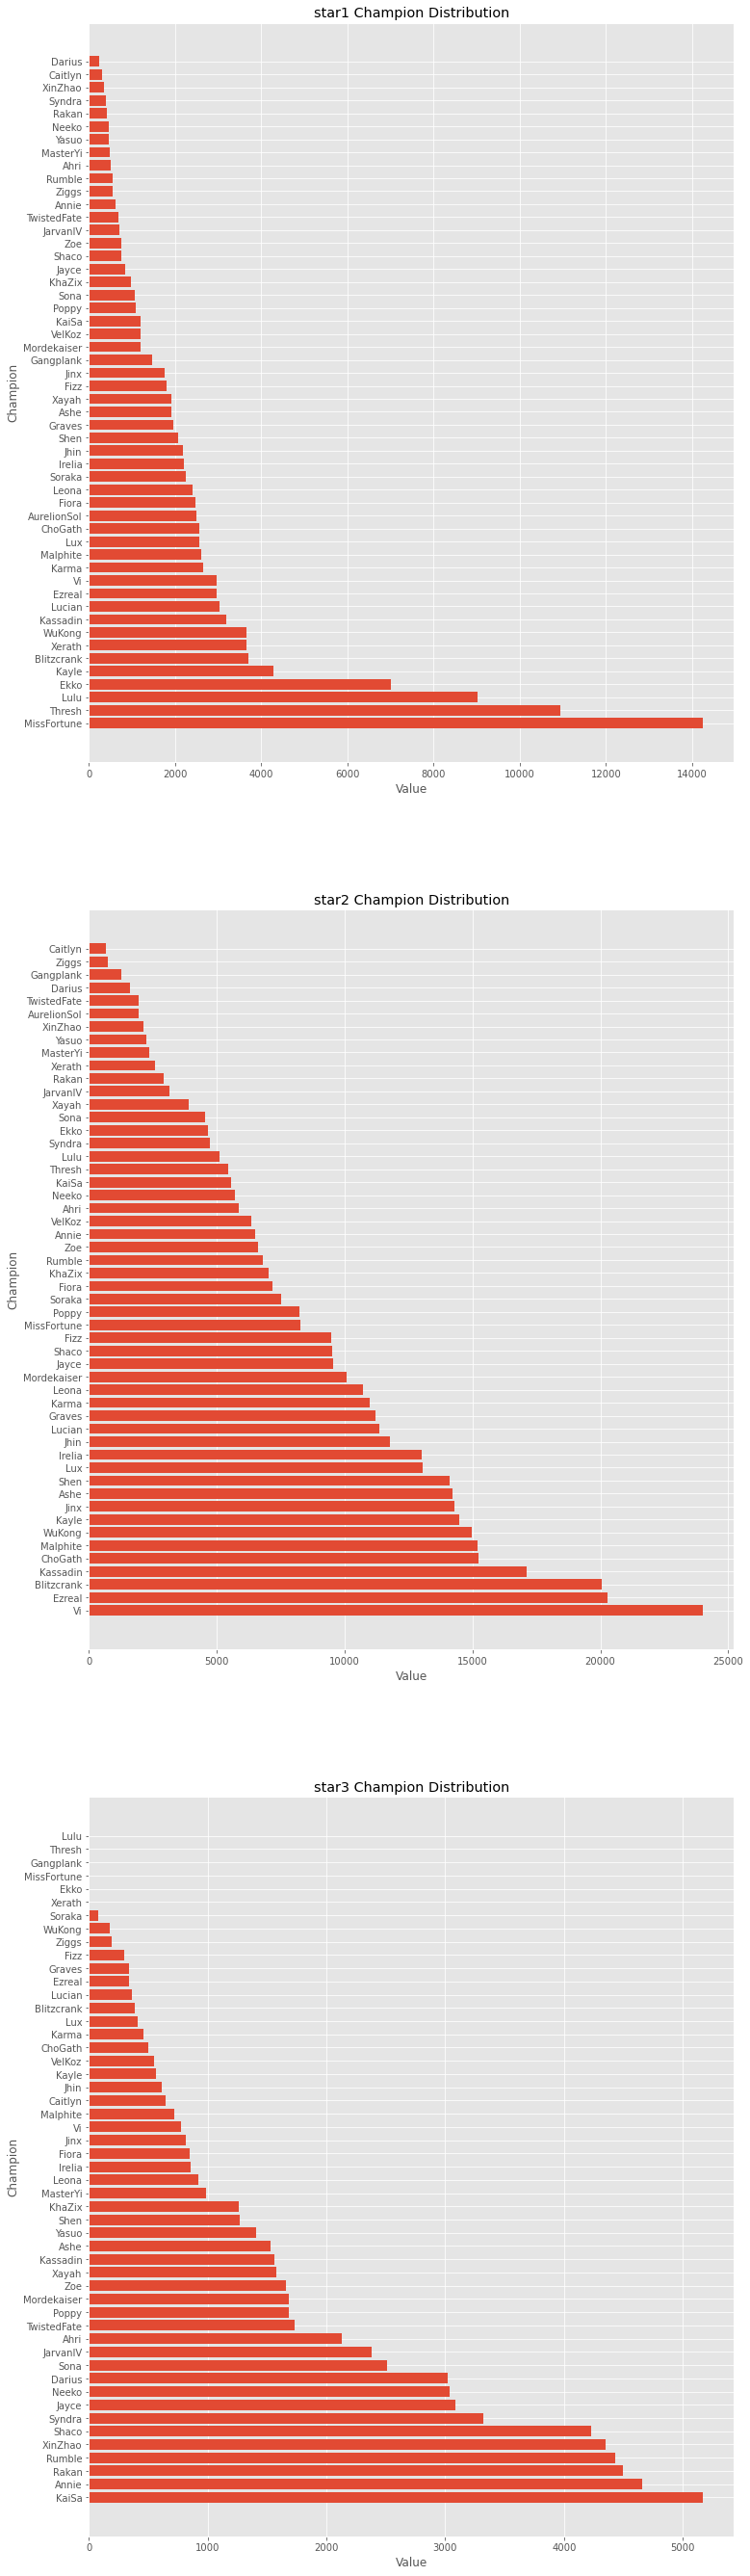

In [114]:
champion_distribution_plot(star1_chall,star2_chall,star3_chall)

- Star1 (1성)

    - 챌린저가 많이 사용한 챔피언 미스포츈, 쓰레쉬, 룰루, 오공, 에코, 블리츠크랭크
    - 용병(mercenary)을 제외하고 대부분 룰루, 에코, 케일 등을 사용함
    - 도전자 사용자 거의 사용되지 않은 챔피언 다리우스, 케이틀린, 신짜오...
        - 별 1개가 있는 사용하지 않는 챔피언은 대부분 별 3개가 사용됩니다.(저비용)
- Star2 (2성)

    - 많이 사용되는 챔피언은 바이, 이즈리얼(노머고), 카사딘
    - 대부분 사용된 1성, 2성 블리츠크랭크
- Star3 (3성)

    - 많이 사용되는 챔피언 카이사, 애니, 라칸, 럼블, 신짜오….
    - 거의 사용되지 않은 챔피언 소라카, 오공, 직스...

### 위의 코드에서 분해한 값은 다음과 같이 나옴

In [116]:
char=chall_game['champion'].iloc[0]
char2 = char.replace("'","\"")
key_ls = list(json.loads(char2).keys())
value_ls = list(json.loads(char2).values())

In [117]:
char

"{'JarvanIV': {'items': [27], 'star': 3}, 'Sona': {'items': [46], 'star': 3}, 'Rakan': {'items': [37, 69], 'star': 3}, 'XinZhao': {'items': [69, 25, 25], 'star': 3}, 'Neeko': {'items': [], 'star': 2}, 'Karma': {'items': [], 'star': 2}, 'Soraka': {'items': [], 'star': 2}, 'Lulu': {'items': [59], 'star': 1}}"

In [118]:
char2

'{"JarvanIV": {"items": [27], "star": 3}, "Sona": {"items": [46], "star": 3}, "Rakan": {"items": [37, 69], "star": 3}, "XinZhao": {"items": [69, 25, 25], "star": 3}, "Neeko": {"items": [], "star": 2}, "Karma": {"items": [], "star": 2}, "Soraka": {"items": [], "star": 2}, "Lulu": {"items": [59], "star": 1}}'

In [119]:
key_ls

['JarvanIV', 'Sona', 'Rakan', 'XinZhao', 'Neeko', 'Karma', 'Soraka', 'Lulu']

In [50]:
value_ls

[{'items': [27], 'star': 3},
 {'items': [46], 'star': 3},
 {'items': [37, 69], 'star': 3},
 {'items': [69, 25, 25], 'star': 3},
 {'items': [], 'star': 2},
 {'items': [], 'star': 2},
 {'items': [], 'star': 2},
 {'items': [59], 'star': 1}]

### 2-1-2 그랜드마스터

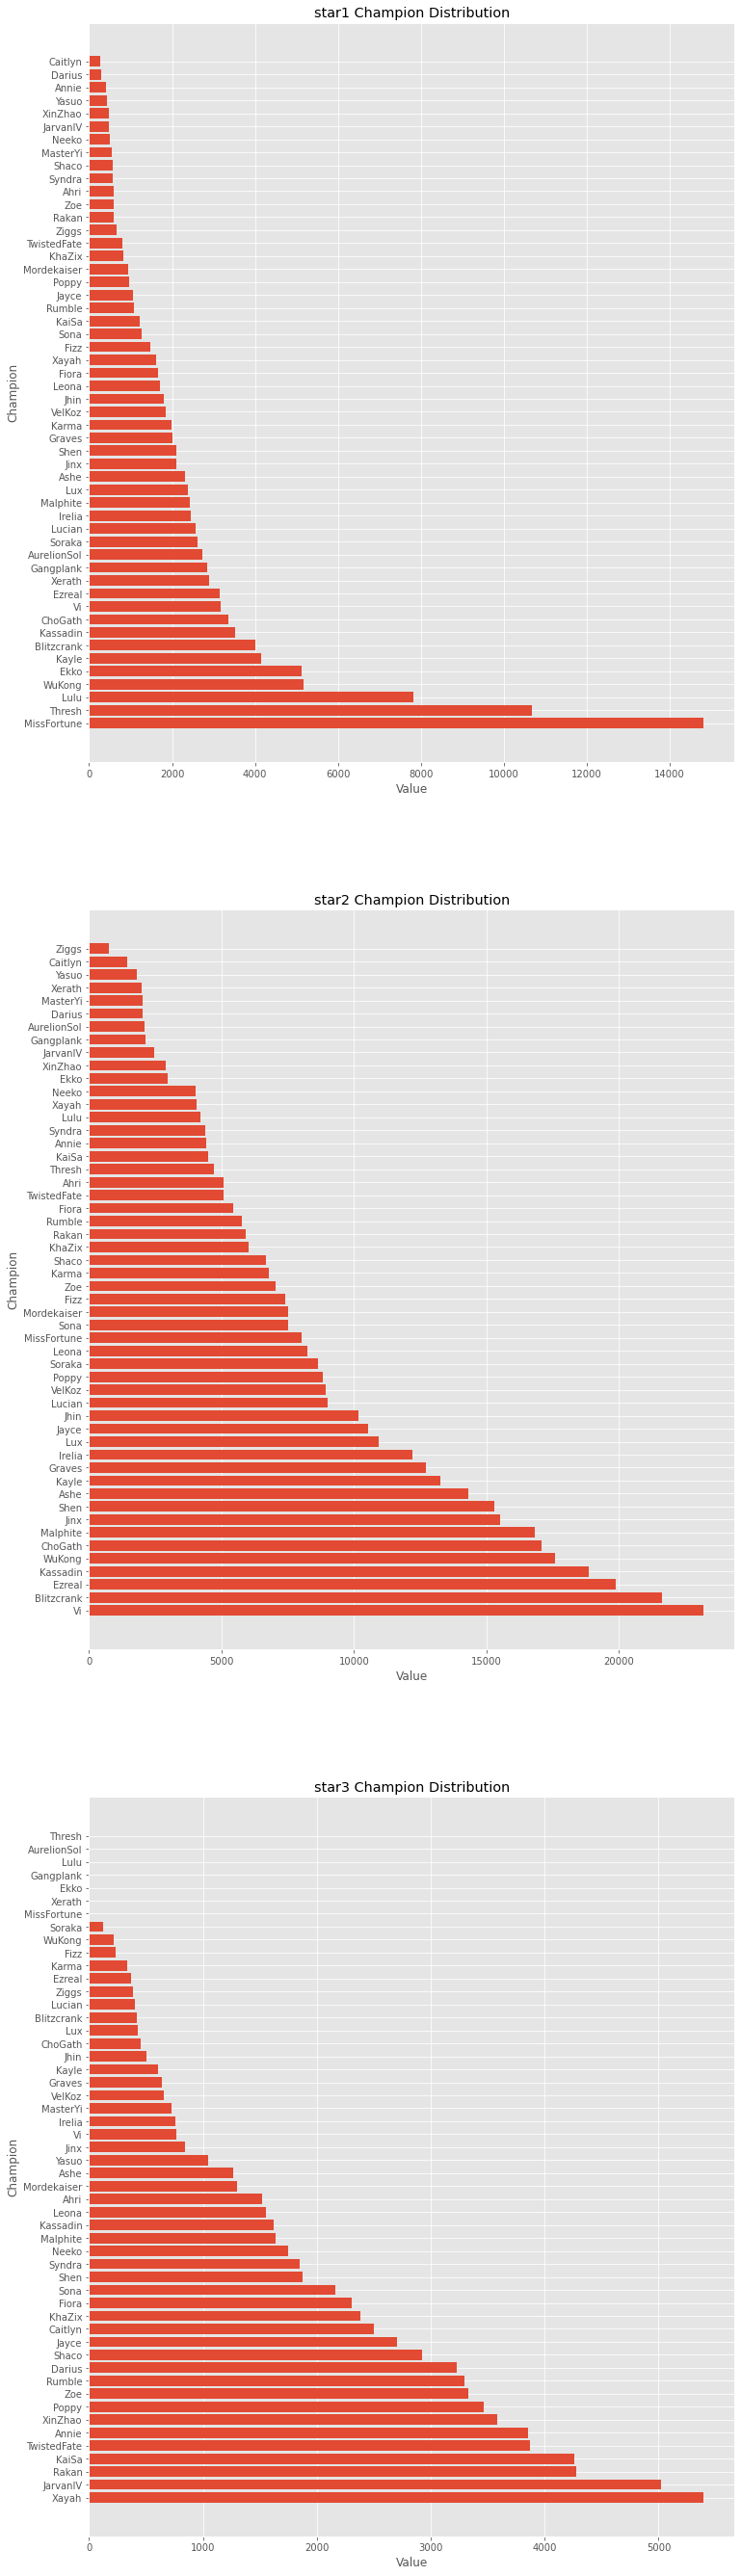

In [51]:
champion_distribution_plot(star1_gma,star2_gma,star3_gma)

- Star1 (1성)

    - 그랜드마스터는 챔피언인 미스포츈, 쓰레쉬, 룰루, 오공, 에코를 많이 사용했습니다.
    - 용병만 빼고 대부분은 룰루, 오공, 에코 사용
    - 그랜드마스터가 거의 사용하지 않는 챔피언 다리우스, 케이틀린, 신짜오...
    - 별 1개가 있는 사용되지 않은 챔피언은 대부분 별 3개가 사용됩니다.(저비용)
- Star2 (2성)

    - 많이 사용된 챔피언 바이, 블릿츠크랭크, 이즈리얼, 카사딘
    - 블릿츠크랭크는 대부분 1성, 2성을 사용했다.
- Star3 (3성)

    - 많이 사용되는 챔피언 자야, 자르반4세, 카이사, 라칸, 트위스트 페이트, 신자오...
    - 거의 쓰이지 않는 챔피언 소라카, 오공, 직스...

#### 그랜드마스터 유저들은 챌린저와 자신이 사용하는 챔피언의 분포가 다르다.

### 2-1-3 마스터

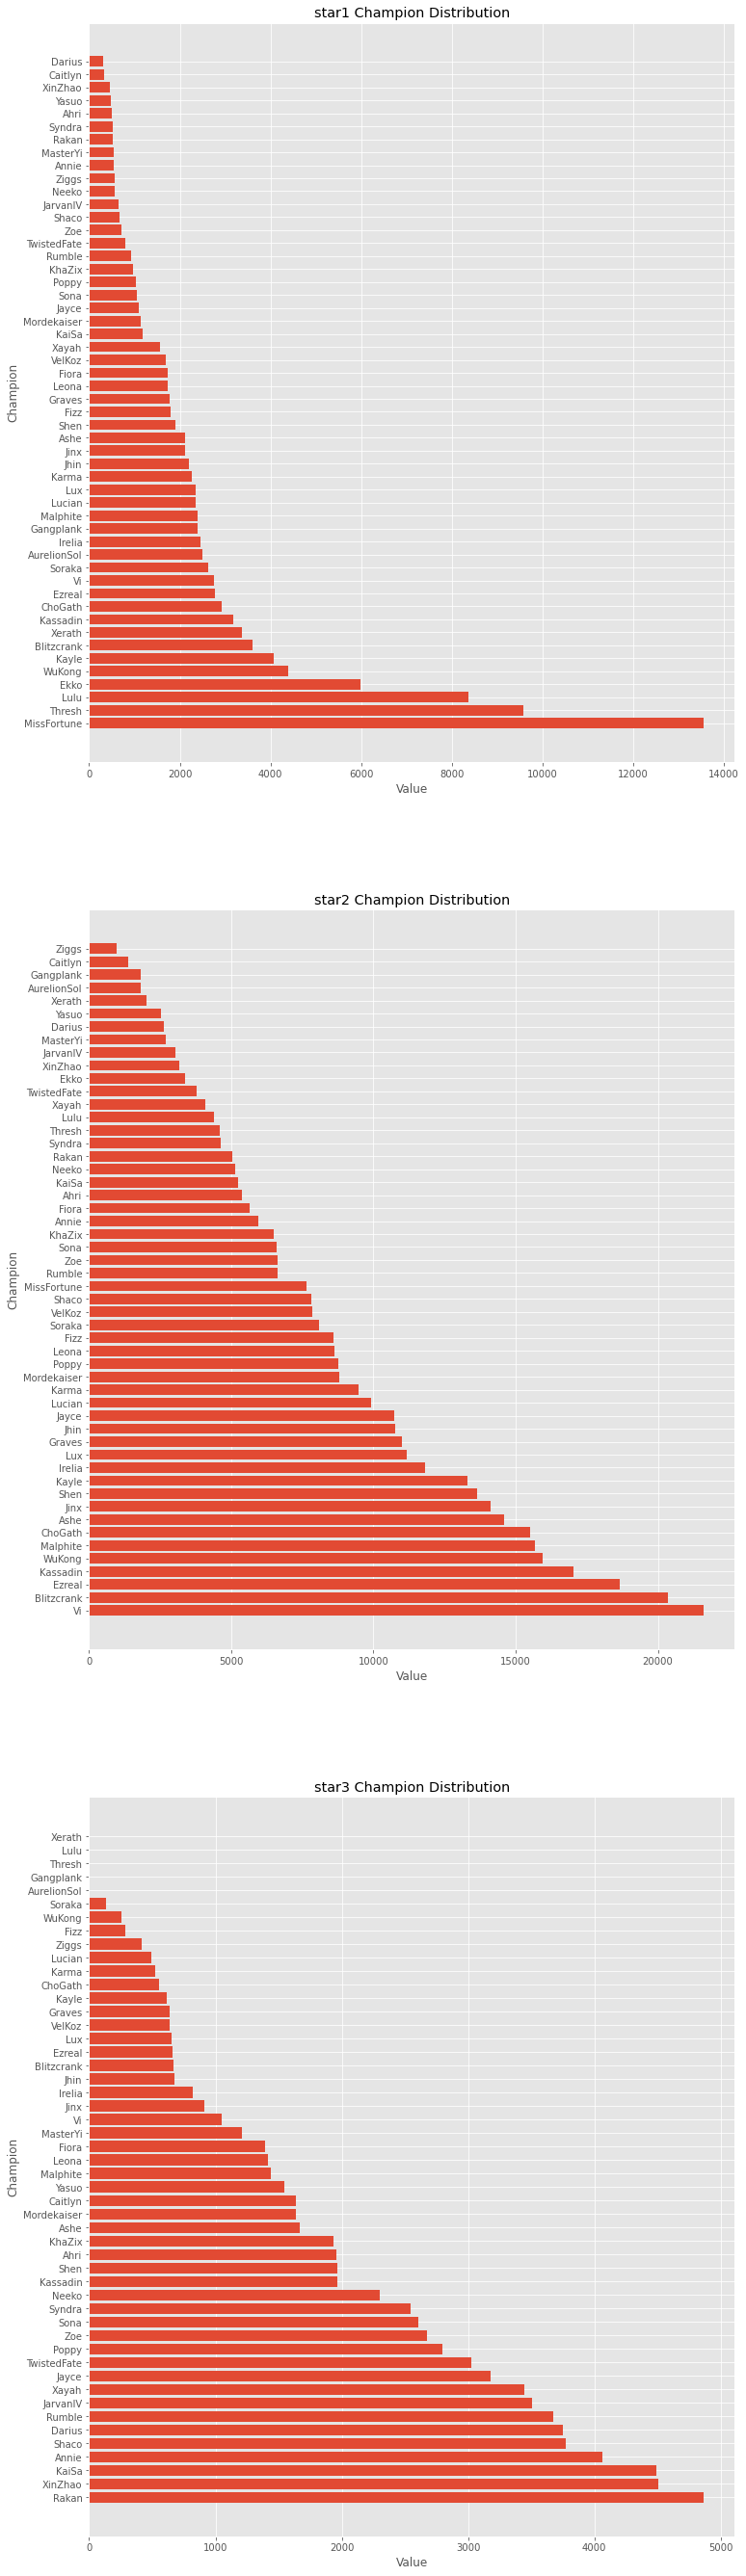

In [52]:
champion_distribution_plot(star1_ma,star2_ma,star3_ma)

#### 마스터 티어 유저들은 챌린저 티어 유저들과 비슷한 챔피언 사용분포를 보여준다

### 2-1-4. Rank1, Rank2 differences distribution
- 챌린저티어를 샘플로

In [53]:
rank1_star1,rank1_star2,rank1_star3=distribution_cleansing(chall_game,1,True)
rank2_star1,rank2_star2,rank2_star3=distribution_cleansing(chall_game,2,True)

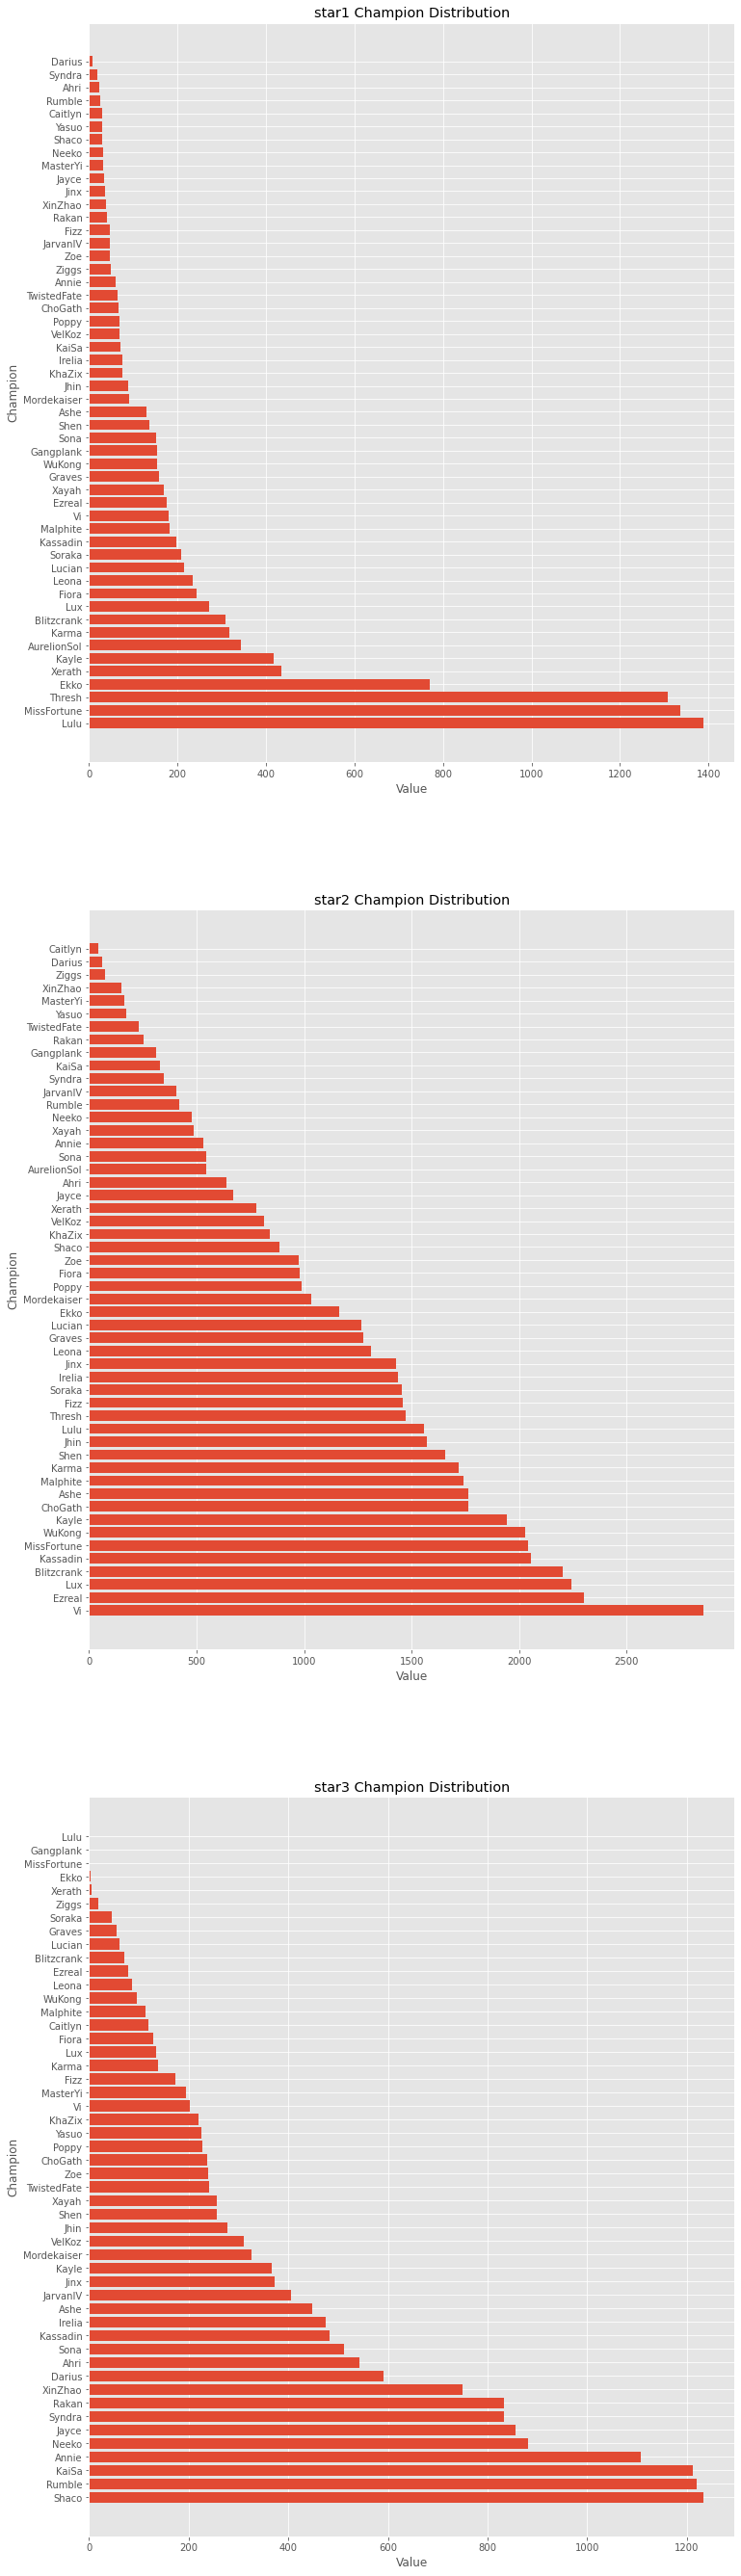

In [54]:
champion_distribution_plot(rank1_star1,rank1_star2,rank1_star3)

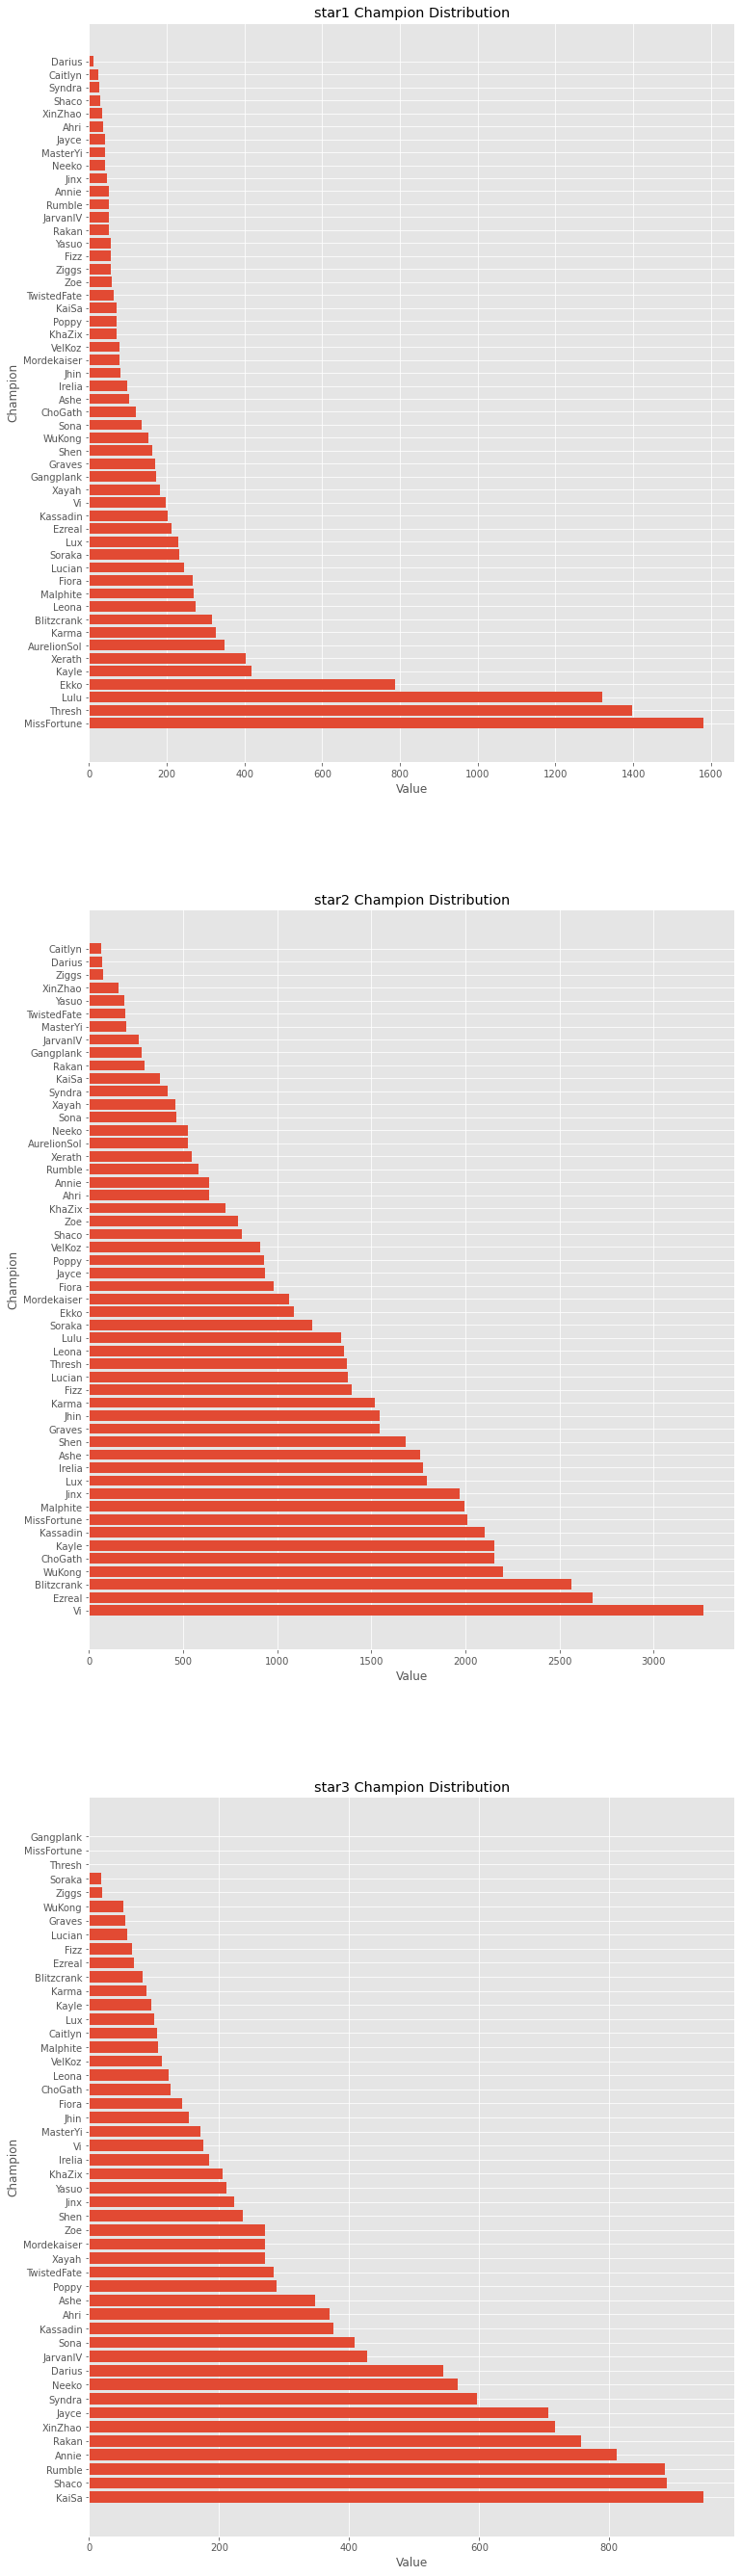

In [55]:
champion_distribution_plot(rank2_star1,rank2_star2,rank2_star3)

- 첫번째 데이터 챔피언과 두번째 데이터 챔피언은 거의 차이가 없다.
- 2성에서는 두번째 데이터와 패턴 차이가 다소 있지만 첫번째 데이터 사용자들은 가장 많이 분포된 바이와 이즈리얼, 블리츠크랭크, 카사딘, 오공, 초가스 등을 제외하면 럭스와 애쉬의 분포가 높다는 것을 알 수 있다.
- 3성의 경우 두번째 데이터는 카이사 분포가 높은 반면 첫번째 데이터는 샤코 분포가 높다. 다만 1위와 2위 모두 카이사, 샤코, 럼블, 애니가 상위 4위에 올라 1위 니코와 제이스의 분포가 비교적 높은 편이다.

### 2-2 조합별 챔피언 분배(종류, 작업)
- 사용자들은 각 조합에 어떤 챔피언을 사용하는지 찾고 있다.

In [62]:
# Function
# 조합명을 추출하는 함수
def combination_champion_distribution(df, combination_name):
    global type_df, work_df, champ
    
    
    if len(work_df[work_df['work']==combination_name]['1st'])==0:
        work_ok = False
        pass
    else:
        minimum_combi = work_df[work_df['work']==combination_name]['1st'].iloc[0]
        work_ok = True
    
    if len(type_df[type_df['type']==combination_name]['1st'])==0:
        pass
    else:
        minimum_combi = type_df[type_df['type']==combination_name]['1st'].iloc[0]

    
    star1_work_champion, star2_work_champion, star3_work_champion = [], [], []
    star1_type_champion, star2_type_champion, star3_type_champion = [], [], []
    
    for i in range(len(df)):
        
        if i != 0 and i % 10000 ==0 :
            print(i)
            
        char = df['combination'].iloc[i]
        char2 = char.replace("'","\"")
        key_ls = list(json.loads(char2).keys())
        value_ls = list(json.loads(char2).values())
        
        
        char_champ = df['champion'].iloc[i]
        char2_champ = char_champ.replace("'","\"")
        key_ls_champ = list(json.loads(char2_champ).keys())
        value_ls_champ = list(json.loads(char2_champ).values())
        
        for j in range(len(key_ls)):
            if key_ls[j] == combination_name:
                
                if value_ls[j] >= minimum_combi:
                    
                    for k in range(len(key_ls_champ)):
                        
                        if work_ok == True:
                            work_list = champ[champ['name'] == key_ls_champ[k].lower()]['class'].iloc[0]
                            work_list2 = re.sub('[^,a-zA-Z0-9]','',str(work_list)).split(',')
                            
                            
                            if combination_name in work_list2:
                                
                                if value_ls_champ[k]['star'] == 1:
                                    star1_work_champion.append(key_ls_champ[k])
                                    
                                elif value_ls_champ[k]['star'] == 2:
                                    star2_work_champion.append(key_ls_champ[k])
                                    
                                elif value_ls_champ[k]['star'] == 3:
                                    star3_work_champion.append(key_ls_champ[k])
                                    
                        else:
                            type_list = champ[champ['name'] == key_ls_champ[k].lower()]['origin'].iloc[0]
                            type_list2 = re.sub('[^,a-zA-Z0-9]','',type_list).split(',')
                            
                            
                            if combination_name in type_list2:
                                
                                if value_ls_champ[k]['star'] == 1:
                                    star1_type_champion.append(key_ls_champ[k])
                                    
                                elif value_ls_champ[k]['star'] == 2:
                                    star2_type_champion.append(key_ls_champ[k])
                                    
                                elif value_ls_champ[k]['star'] == 3:
                                    star3_type_champion.append(key_ls_champ[k])
                            
                        
                    
                else:
                    continue
                    
            else:
                continue
    
    if  star1_work_champion == []:
        
        return star1_type_champion,star2_type_champion,star3_type_champion
    
    else:
        return star1_work_champion,star2_work_champion,star3_work_champion
    
    
def combination_champion_distribution_plot(star1, star2, star3,combination):

    fig,axes = plt.subplots(3,1,figsize = (12,48))

    plot_key0 = pd.Series(star1).value_counts().keys().tolist()
    plot_value0 = pd.Series(star1).value_counts().values.tolist()

    plot_key1 = pd.Series(star2).value_counts().keys().tolist()
    plot_value1 = pd.Series(star2).value_counts().values.tolist()

    plot_key2 = pd.Series(star3).value_counts().keys().tolist()
    plot_value2 = pd.Series(star3).value_counts().values.tolist()



    for idx,ls,ax in zip(['star1','star2','star3'],[[plot_key0,plot_value0],[plot_key1,plot_value1],[plot_key2,plot_value2]],axes):

        ax.barh(ls[0],ls[1])

        #ax.set_title('{} 이웃'.format(n_neighbors))
        ax.set_xlabel('Value')
        ax.set_ylabel('Champion')
        ax.set_title(combination+' '+idx + ' Champion Distribution')

global : 함수바깥에서 사용하기 위한 전역변수

#### 2-2-1 챌린저

1. type example
    - Rebel(반란군)
    - DarkStar(암흑의 별)

2. work example
    - Protector(수호자)
    - Blaster(총잡이)

#### Type

In [63]:
type_df

,type,1st,2nd,3rd
0,SpacePirate,2,4.0,NaN
1,StarGuardian,3,6.0,NaN
2,Set3_Celestial,2,4.0,6.0
3,DarkStar,3,6.0,9.0
4,MechPilot,3,NaN,NaN
5,Cybernetic,3,6.0,NaN
6,Rebel,3,6.0,9.0
7,Valkyrie,2,NaN,NaN
8,Set3_Void,3,NaN,NaN
9,Chrono,2,4.0,6.0


In [64]:
star1_champion, star2_champion, star3_champion = combination_champion_distribution(chall_game,'Rebel')

10000
20000
30000
40000
50000
60000
70000


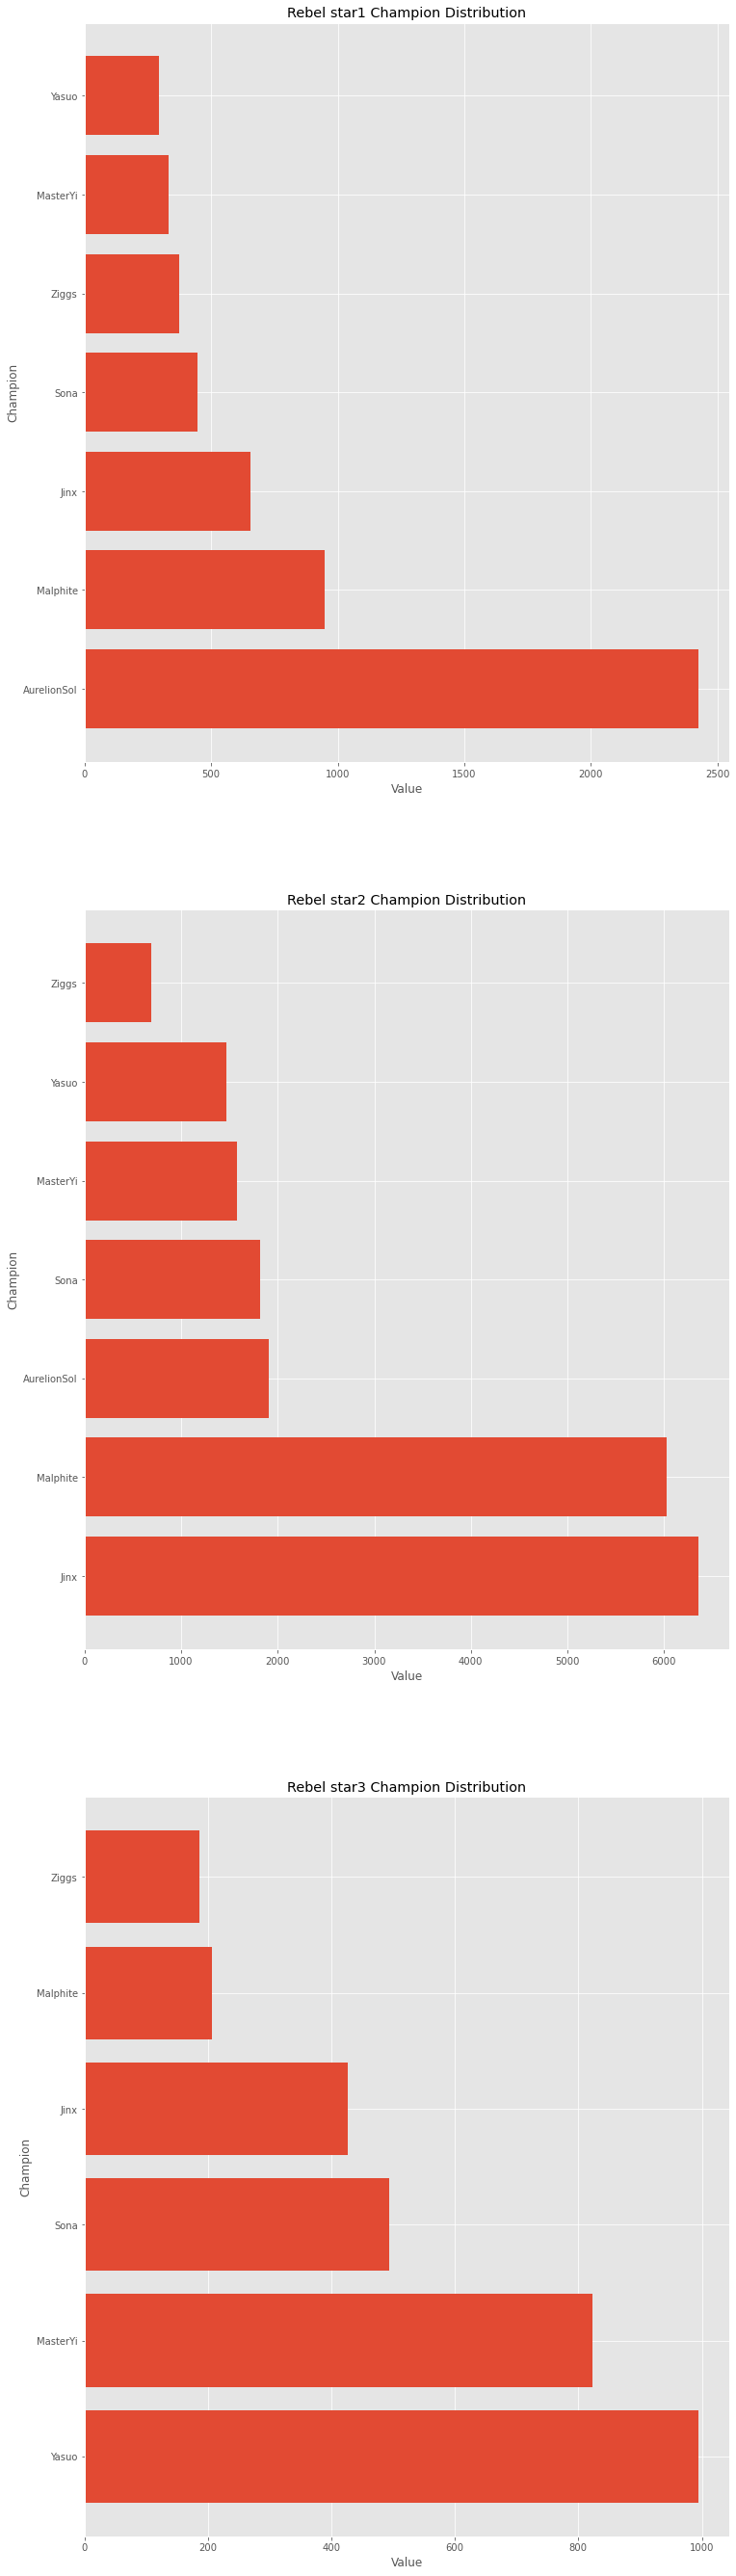

In [66]:
combination_champion_distribution_plot(star1_champion,star2_champion,star3_champion,'Rebel')

- 야스오, 마스터이는 거의 3성으로 조합을 완성한다
- 말파이트, 징크스는 대개 2성까지만 완성한다
- 직스는 2성, 3성아니면 없음

In [67]:
star1_champion, star2_champion, star3_champion = combination_champion_distribution(chall_game,'DarkStar')

10000
20000
30000
40000
50000
60000
70000


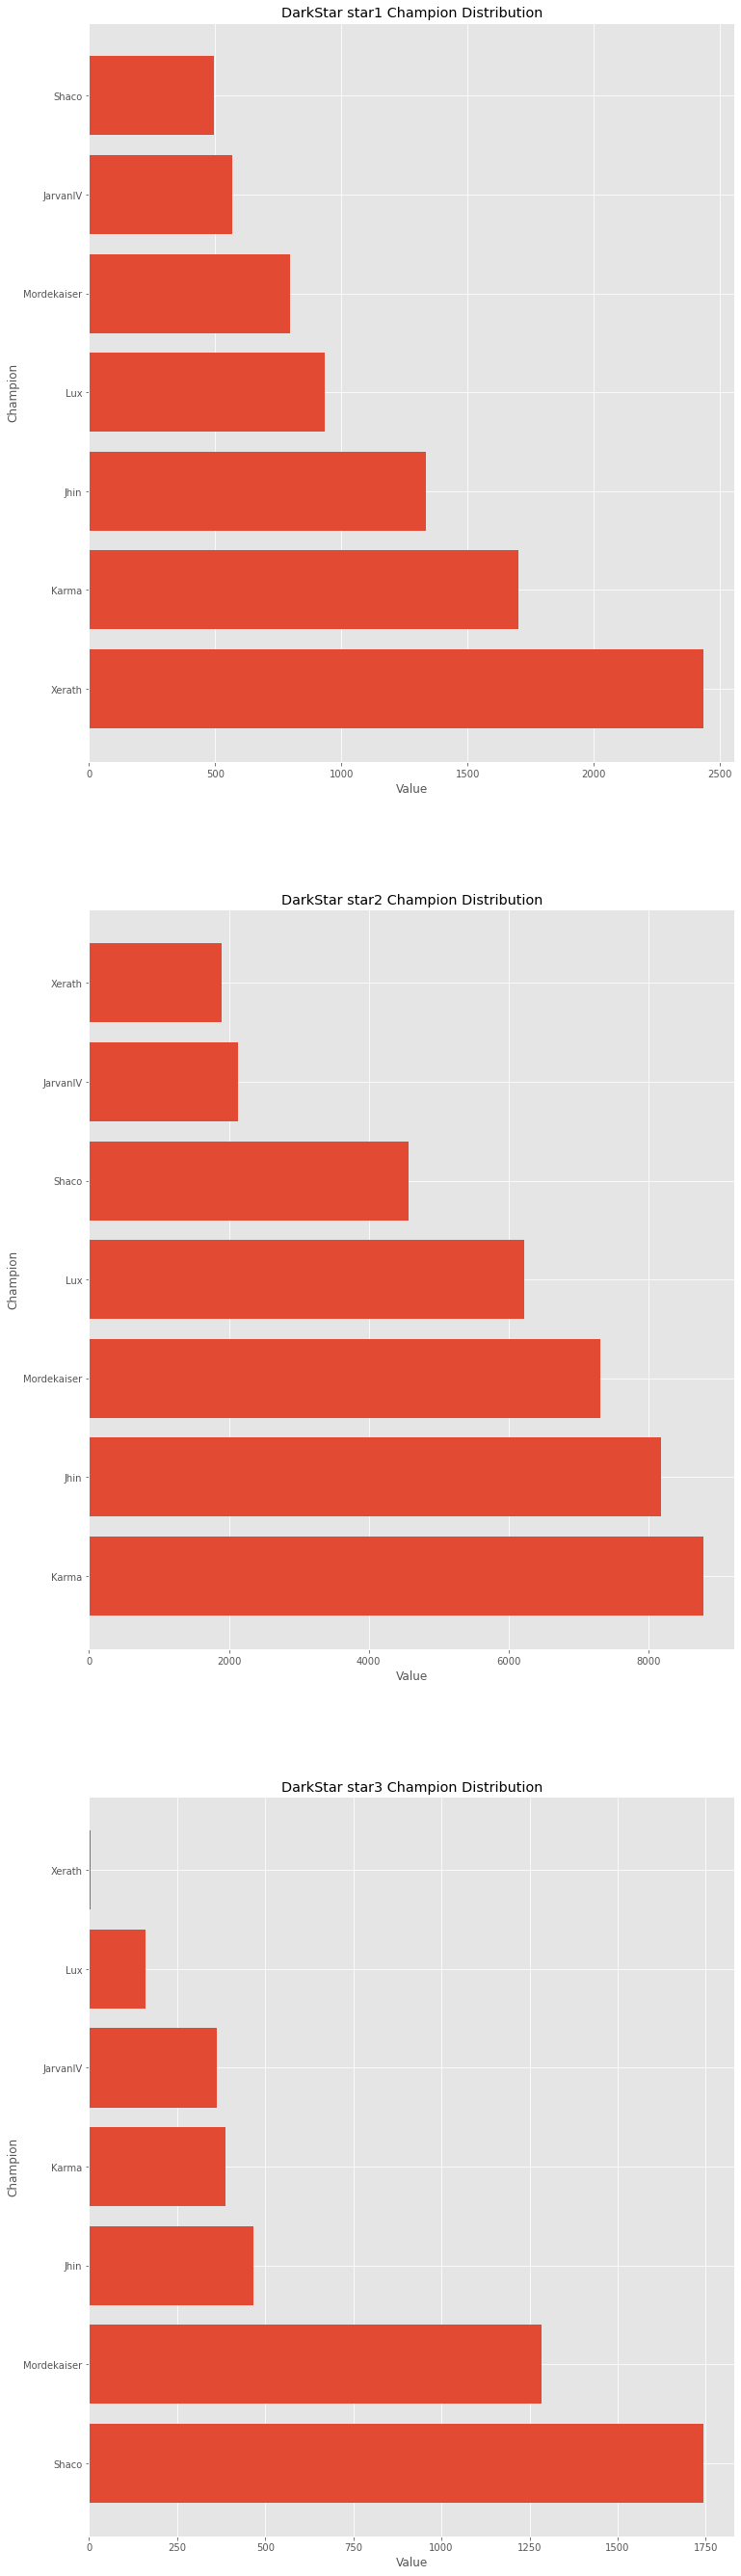

In [68]:
combination_champion_distribution_plot(star1_champion,star2_champion,star3_champion,'DarkStar')

- 제라스는 주로 1성에 사용
- 카르마는 거의 1성 아니면 2성에 사용
- 샤코는 종종 3성에 사용되지만 1성만 사용하는 경우도 있다
- 전체적으로 자르반의 분포가 낮다.
- 진, 럭스, 모데카이저는 골고루 사용된다

#### work

In [69]:
work_df

,work,1st,2nd,3rd,4th
0,Set3_Blademaster,3,6.0,9.0,NaN
1,Blaster,2,4.0,NaN,NaN
2,Set3_Brawler,2,4.0,NaN,NaN
3,Demolitionist,2,NaN,NaN,NaN
4,Infiltrator,2,4.0,6.0,NaN
5,ManaReaver,2,NaN,NaN,NaN
6,Mercenary,1,NaN,NaN,NaN
7,Set3_Mystic,2,4.0,NaN,NaN
8,Protector,2,4.0,6.0,NaN
9,Sniper,2,NaN,NaN,NaN


In [70]:
star1_champion,star2_champion,star3_champion=combination_champion_distribution(chall_game,'Protector')

10000
20000
30000
40000
50000
60000
70000


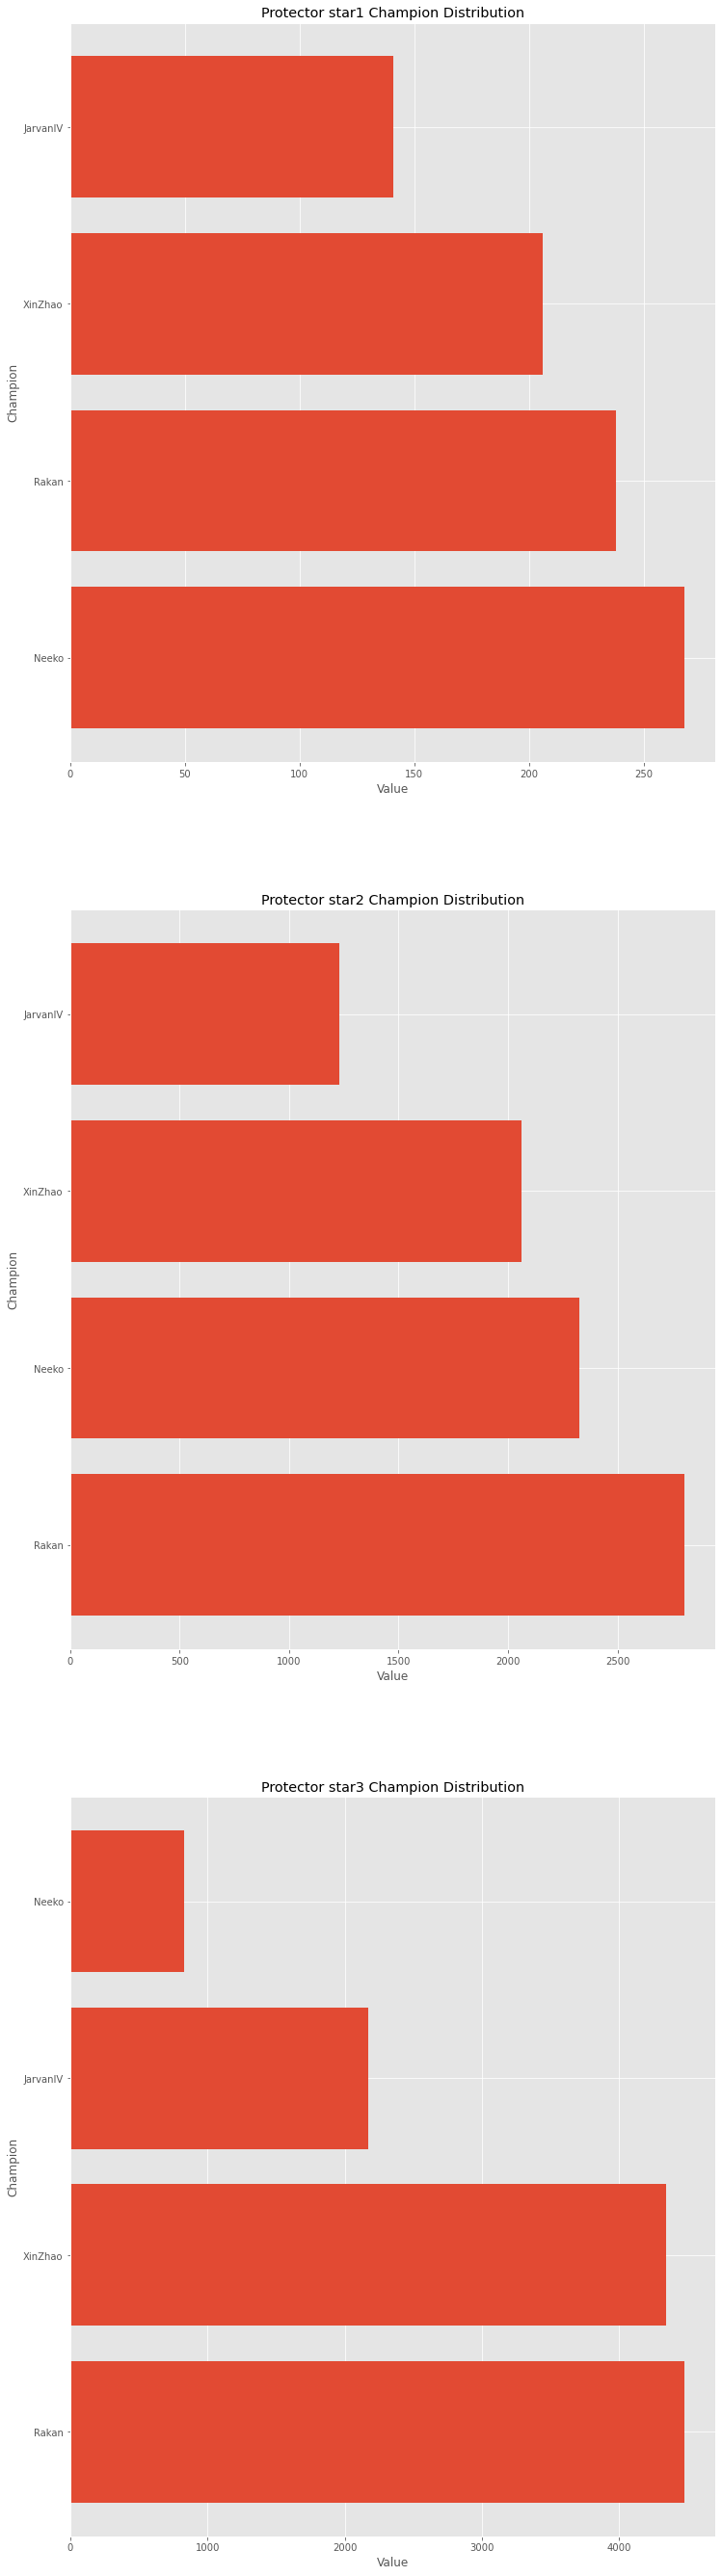

In [71]:
combination_champion_distribution_plot(star1_champion,star2_champion,star3_champion,'Protector')

- 모든 구간에서 라칸의 분포가 높은 것을 확인할 수 있음
- 니코는 1,2성에서는 많이 쓰이지만, 3성에서는 많이 쓰이지 않음

In [72]:
star1_champion, star2_champion, star3_champion = combination_champion_distribution(chall_game,'Blaster')

10000
20000
30000
40000
50000
60000
70000


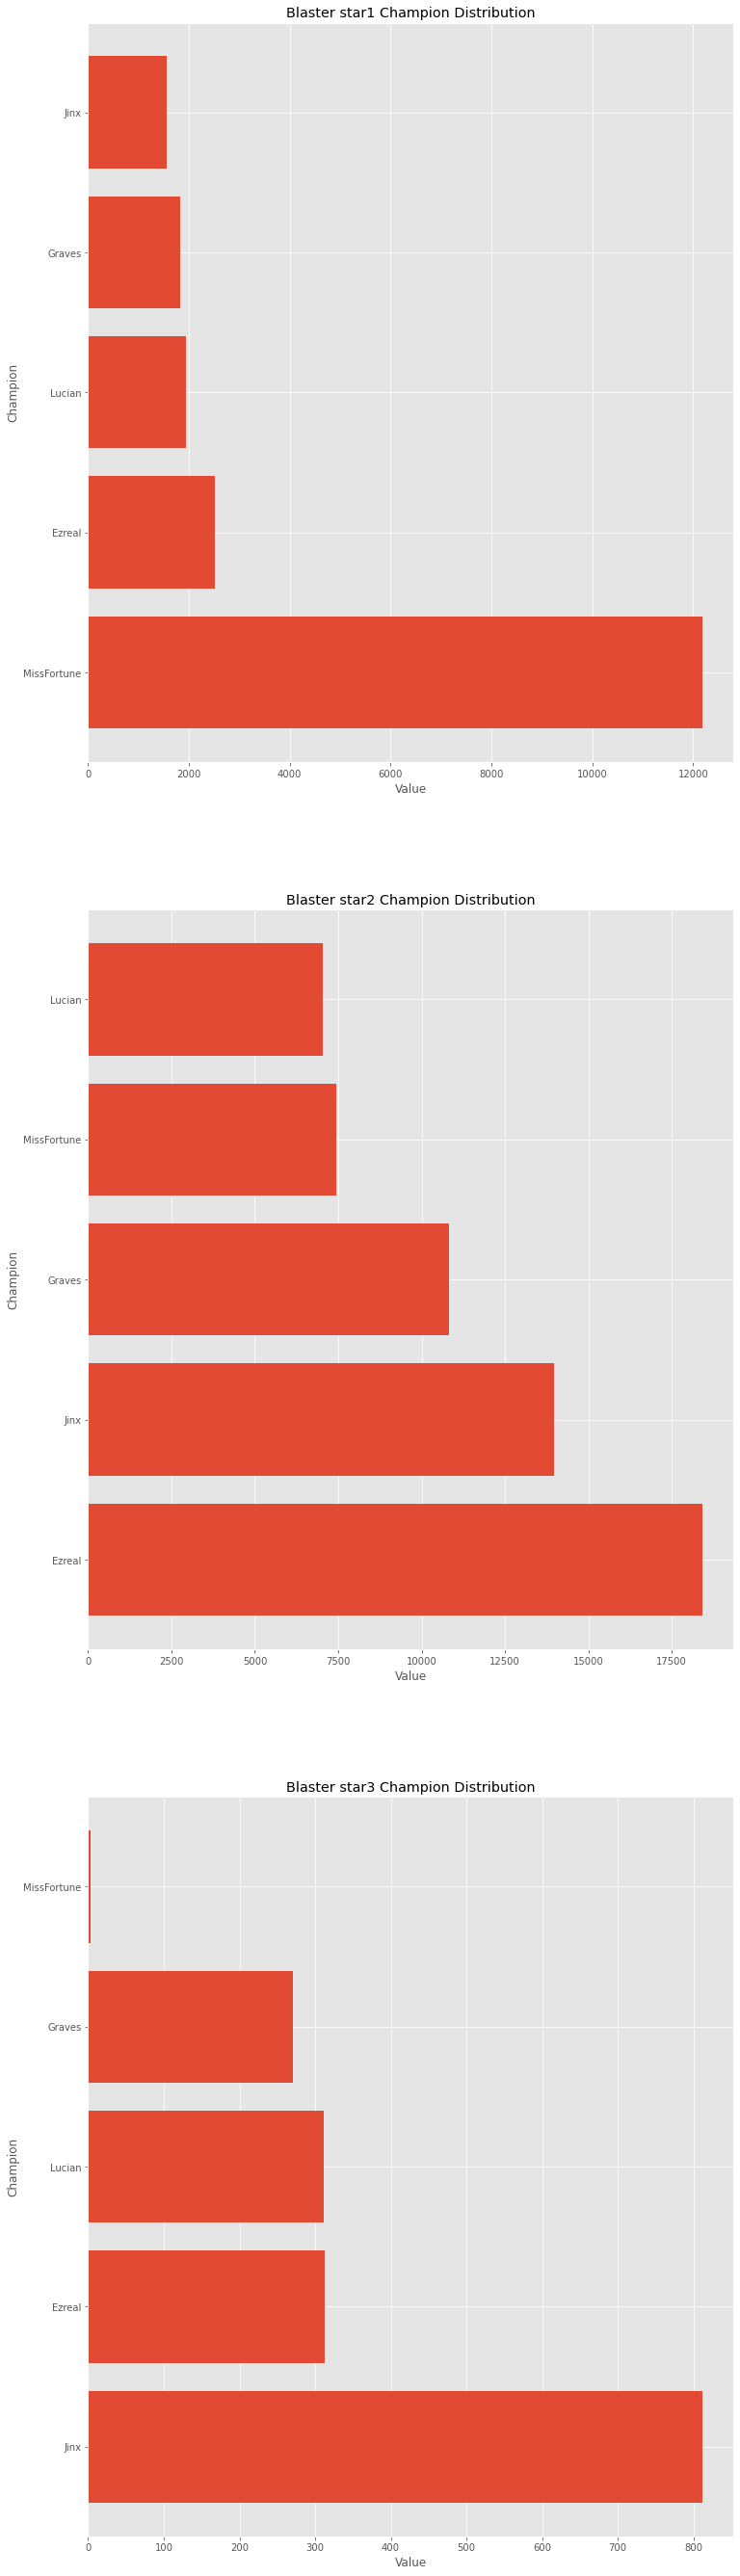

In [73]:
combination_champion_distribution_plot(star1_champion,star2_champion,star3_champion,'Blaster')

- 징크스는 1성으로는 많이 쓰이지는 않지만, 2성, 3성으로 많이 쓰이고 있음
- 루시안과 그레이브즈의 분포는 저조함
- 이즈리얼의 사용률이 높은 것을 확인할 수 있음

In [77]:
chall_game['combination']

0        {'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...
1        {'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...
2        {'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...
3        {'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...
4        {'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...
                               ...                        
79994    {'DarkStar': 2, 'Demolitionist': 2, 'Infiltrat...
79995    {'Blaster': 1, 'Chrono': 2, 'Cybernetic': 6, '...
79996    {'Chrono': 2, 'Cybernetic': 1, 'Demolitionist'...
79997    {'Blaster': 4, 'Chrono': 2, 'Cybernetic': 1, '...
79998    {'ManaReaver': 2, 'Protector': 2, 'Set3_Celest...
Name: combination, Length: 79992, dtype: object

In [82]:
char = chall_game['combination'].iloc[1]
char2 = char.replace("'","\"")

In [83]:
char2

'{"Blaster": 2, "Mercenary": 1, "Rebel": 6, "Set3_Blademaster": 3, "Set3_Brawler": 1, "Set3_Mystic": 2, "StarGuardian": 1, "Starship": 1, "Valkyrie": 2}'

In [84]:
key_ls = list(json.loads(char2).keys())
key_ls

['Blaster',
 'Mercenary',
 'Rebel',
 'Set3_Blademaster',
 'Set3_Brawler',
 'Set3_Mystic',
 'StarGuardian',
 'Starship',
 'Valkyrie']

In [86]:
value_ls = list(json.loads(char2).values())
value_ls

[2, 1, 6, 3, 1, 2, 1, 1, 2]

In [88]:
char_champ = chall_game['champion'].iloc[0]
char2_champ = char_champ.replace("'","\"")
key_ls_champ = list(json.loads(char2_champ).keys())
value_ls_champ = list(json.loads(char2_champ).values())

In [91]:
char_champ

"{'JarvanIV': {'items': [27], 'star': 3}, 'Sona': {'items': [46], 'star': 3}, 'Rakan': {'items': [37, 69], 'star': 3}, 'XinZhao': {'items': [69, 25, 25], 'star': 3}, 'Neeko': {'items': [], 'star': 2}, 'Karma': {'items': [], 'star': 2}, 'Soraka': {'items': [], 'star': 2}, 'Lulu': {'items': [59], 'star': 1}}"

In [122]:
work_df[work_df['work']=='Blaster']['1st'].iloc[0]

2

In [126]:
type_df[type_df['type']=='DarkStar']['1st'].iloc[0]

3